In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

In [35]:
df_alt = pd.read_csv(r"C:\Users\mvana\Documents\MSc\Temp_O3_H2O\Data\saber_agg.csv")
df_alt['year_month'] = pd.to_datetime(df_alt['year_month']).dt.to_period('M')

In [36]:
df = df_alt.groupby(['year_month', 'year', 'month'])[['ktemp']].mean().reset_index()

In [37]:
df = df.sort_values('year_month').reset_index(drop=True)

# Convert 'year_month' from period to datetime for plotting
df['date'] = df['year_month'].dt.to_timestamp()

# Add time index for trend fitting
df['time_index'] = np.arange(len(df))
X = df[['time_index']]
y = df['ktemp']

In [38]:
# Linear Trend Fitting ---
linreg = LinearRegression()
linreg.fit(X, y)
df['trend'] = linreg.predict(X)

# Residual Modeling (ARIMA) ---
df['residual'] = df['ktemp'] - df['trend']
arima_model = ARIMA(df['residual'], order=(1, 0, 0))  # Try (1,1,1) or use auto_arima for optimal
arima_fit = arima_model.fit()

In [39]:
# Projection
future_months = 60  # Project 5 years
future_index = np.arange(len(df), len(df) + future_months)
future_dates = pd.date_range(start=df['date'].iloc[-1] + pd.offsets.MonthBegin(), periods=future_months, freq='MS')
future_trend = linreg.predict(future_index.reshape(-1, 1))
future_resid = arima_fit.forecast(steps=future_months)
future_projection = future_trend + future_resid

C:\Users\mvana\.conda\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [40]:
# Combine into a DataFrame
df_future = pd.DataFrame({
    'date': future_dates,
    'ktemp_projected': future_projection
})

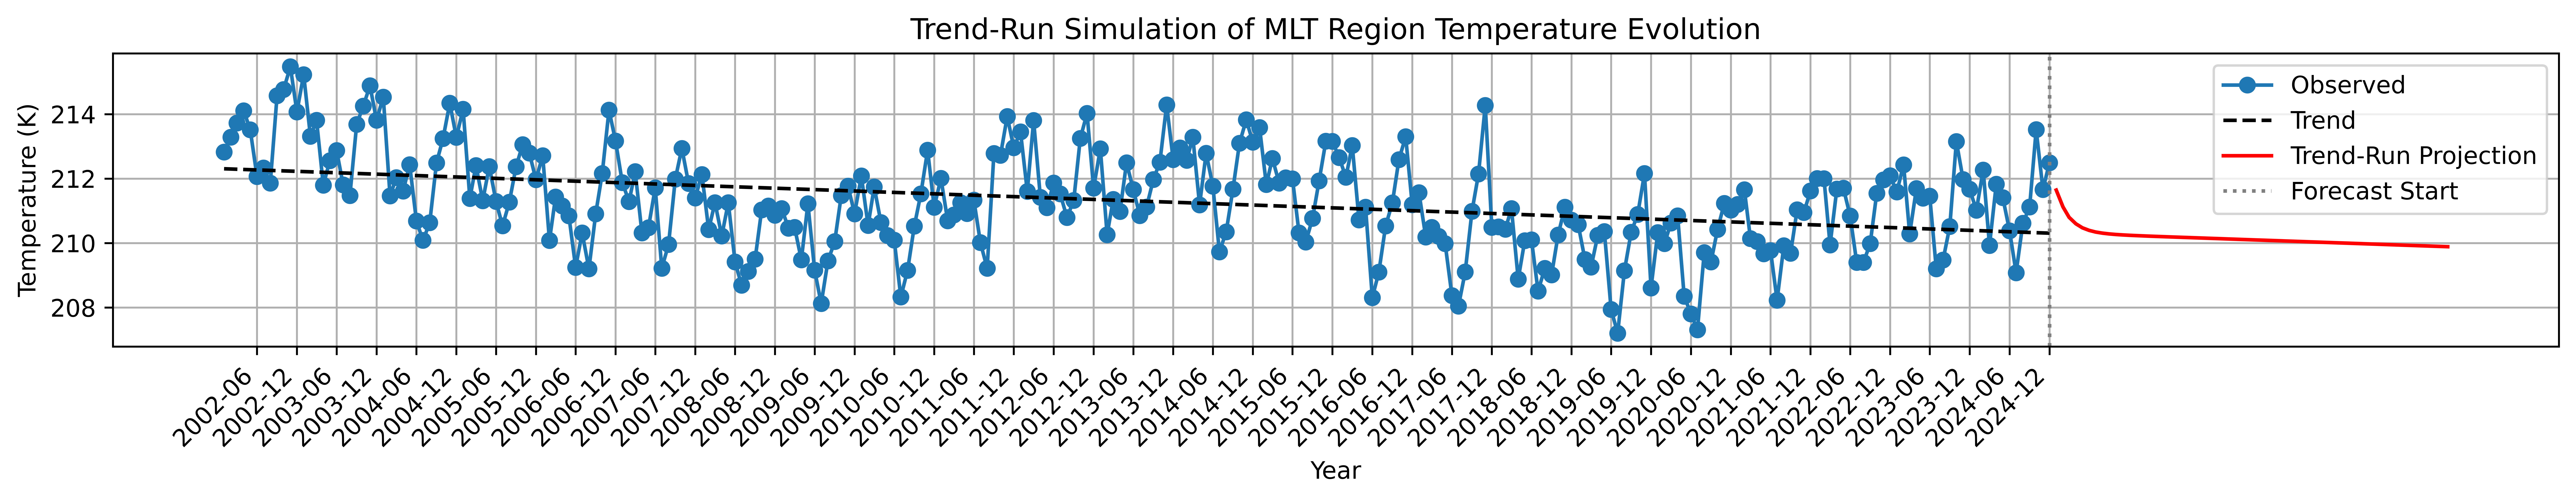

In [42]:
# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])
df_future['date'] = pd.to_datetime(df_future['date'])

# Start plotting
plt.figure(figsize=(15, 3), dpi=1000)
plt.plot(df['date'], df['ktemp'], label='Observed', marker='o')
plt.plot(df['date'], df['trend'], label='Trend', linestyle='--', color='black')
plt.plot(df_future['date'], df_future['ktemp_projected'], label='Trend-Run Projection', color='red')
plt.axvline(df['date'].iloc[-1], color='gray', linestyle=':', label='Forecast Start')

# Filter ticks: only June and December
desired_ticks = []
desired_labels = []

for date in df['date']:
    if date.month in [6, 12]:
        desired_ticks.append(date)
        desired_labels.append(date.strftime('%Y-%m'))

# Set x-axis ticks and labels
plt.xticks(ticks=desired_ticks, labels=desired_labels, rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')
plt.title('Trend-Run Simulation of MLT Region Temperature Evolution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()